In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import gc
import pandas as pd
import os
import kagglehub
print("Locating dataset...")
path = kagglehub.dataset_download("mczielinski/bitcoin-historical-data")
csv_file = [f for f in os.listdir(path) if f.endswith('.csv')][0]
full_file_path = os.path.join(path, csv_file)
print(f"Reading {csv_file} in optimized mode...")
try:
    df = pd.read_csv(full_file_path, low_memory=False).tail(1000000)
    print("Dataset loaded successfully!")
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
    df.set_index('Timestamp', inplace=True)
    df = df.resample('1h').mean()
    df.dropna(inplace=True)
    df = df.astype('float32')
    display(df.head())
except MemoryError:
    print("RAM limit hit! Try loading fewer rows using .tail() or nrows.")

Locating dataset...
Using Colab cache for faster access to the 'bitcoin-historical-data' dataset.
Reading btcusd_1-min_data.csv in optimized mode...
Dataset loaded successfully!


,Open,High,Low,Close,Volume
Timestamp,,,,,
2024-03-04 18:00:00,65368.050781,65399.785156,65332.566406,65365.132812,2.276369
2024-03-04 19:00:00,65574.796875,65645.179688,65502.148438,65587.500000,7.770366
2024-03-04 20:00:00,66264.500000,66323.500000,66216.703125,66271.703125,4.282095
2024-03-04 21:00:00,66531.546875,66585.046875,66474.070312,66529.531250,3.811365
2024-03-04 22:00:00,66957.601562,67029.265625,66895.335938,66962.867188,6.279069


In [2]:
df['MA20'] = df['Close'].rolling(window=20).mean()
df['20std'] = df['Close'].rolling(window=20).std()
df['Upper_Band'] = df['MA20'] + (df['20std'] * 2)
df['Lower_Band'] = df['MA20'] - (df['20std'] * 2)
df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA12'] - df['EMA26']
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
df['RSI'] = 100 - (100 / (1 + (gain / loss)))
df.dropna(inplace=True)

In [3]:
from sklearn.preprocessing import StandardScaler
features = ['Close', 'MA20', 'RSI', 'MACD', 'Upper_Band', 'Lower_Band']
dataset = df[features].values
train_size = int(len(dataset) * 0.8)
scaler = StandardScaler()
train_scaled = scaler.fit_transform(dataset[:train_size])
test_scaled = scaler.transform(dataset[train_size:])
def create_sequences(data, seq_length=24):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:(i + seq_length), :])
        y.append(data[i + seq_length, 0])
    return np.array(x), np.array(y)
X_train, y_train = create_sequences(train_scaled)
X_test, y_test = create_sequences(test_scaled)

In [4]:
from tensorflow.keras import layers, models, callbacks
model = models.Sequential([
    layers.LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    layers.Dropout(0.2),
    layers.LSTM(units=32, return_sequences=False),
    layers.Dropout(0.2),
    layers.Dense(units=1)
])
model.compile(optimizer='adam', loss=tf.keras.losses.Huber())
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.1, callbacks=[early_stop])

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0565 - val_loss: 0.0019
Epoch 2/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0060 - val_loss: 0.0022
Epoch 3/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0054 - val_loss: 6.1152e-04
Epoch 4/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0050 - val_loss: 6.0180e-04
Epoch 5/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0048 - val_loss: 0.0022
Epoch 6/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0046 - val_loss: 0.0010
Epoch 7/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0044 - val_loss: 4.3468e-04
Epoch 8/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0044 - val_loss: 4.8789e-04
Epoch 9/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0044 - val_loss: 0.0023
Epoch 10/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0043 - val_loss: 6.6021e-04
Epoch 11/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0043 - val_loss: 5.8885e-04
Epoch 12/30
187/187 ━━━━━━━━

104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


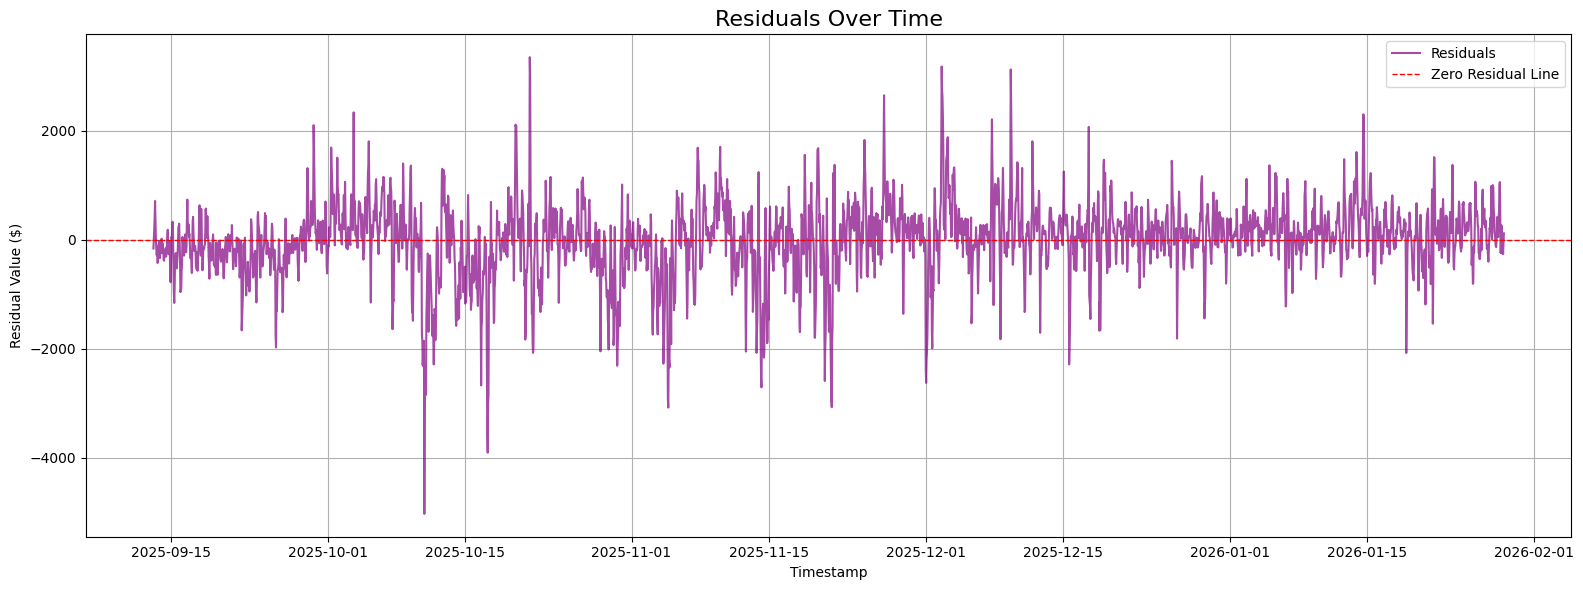

In [5]:
import matplotlib.pyplot as plt
if 'y_test_real' not in locals() or 'predictions_unscaled' not in locals() or 'residuals' not in locals():
    predictions = model.predict(X_test)
    pred_expanded = np.zeros((len(predictions), len(features)))
    pred_expanded[:, 0] = predictions.flatten()
    predictions_unscaled = scaler.inverse_transform(pred_expanded)[:, 0]
    y_test_expanded = np.zeros((len(y_test), len(features)))
    y_test_expanded[:, 0] = y_test
    y_test_real = scaler.inverse_transform(y_test_expanded)[:, 0]
    residuals = y_test_real - predictions_unscaled
plt.figure(figsize=(16, 6))
plt.plot(df.index[-len(y_test_real):], residuals, label='Residuals', color='purple', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=1, label='Zero Residual Line')
plt.title('Residuals Over Time', fontsize=16)
plt.xlabel('Timestamp')
plt.ylabel('Residual Value ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

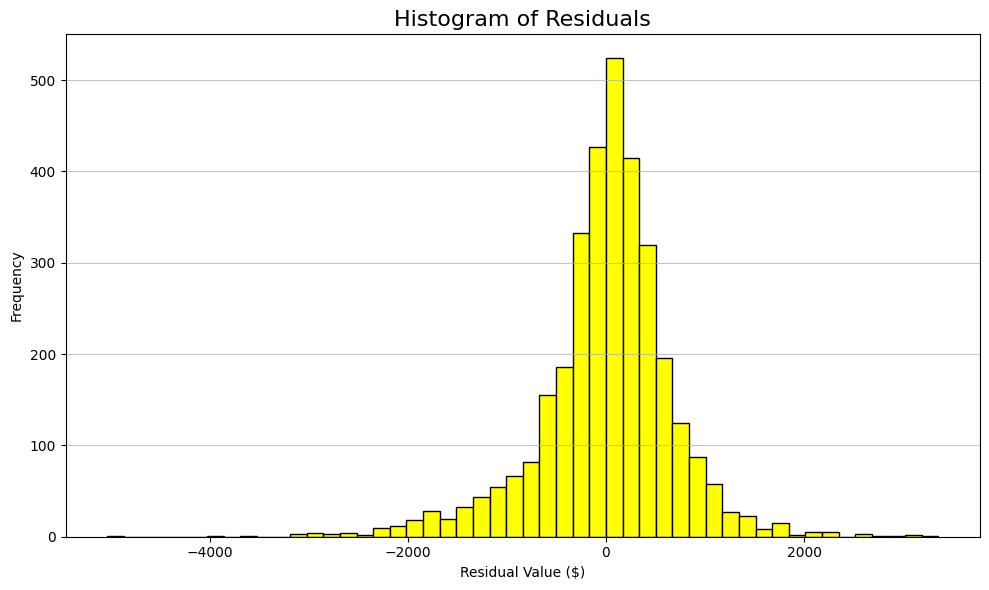

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, color='yellow', edgecolor='black')
plt.title('Histogram of Residuals', fontsize=16)
plt.xlabel('Residual Value ($)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

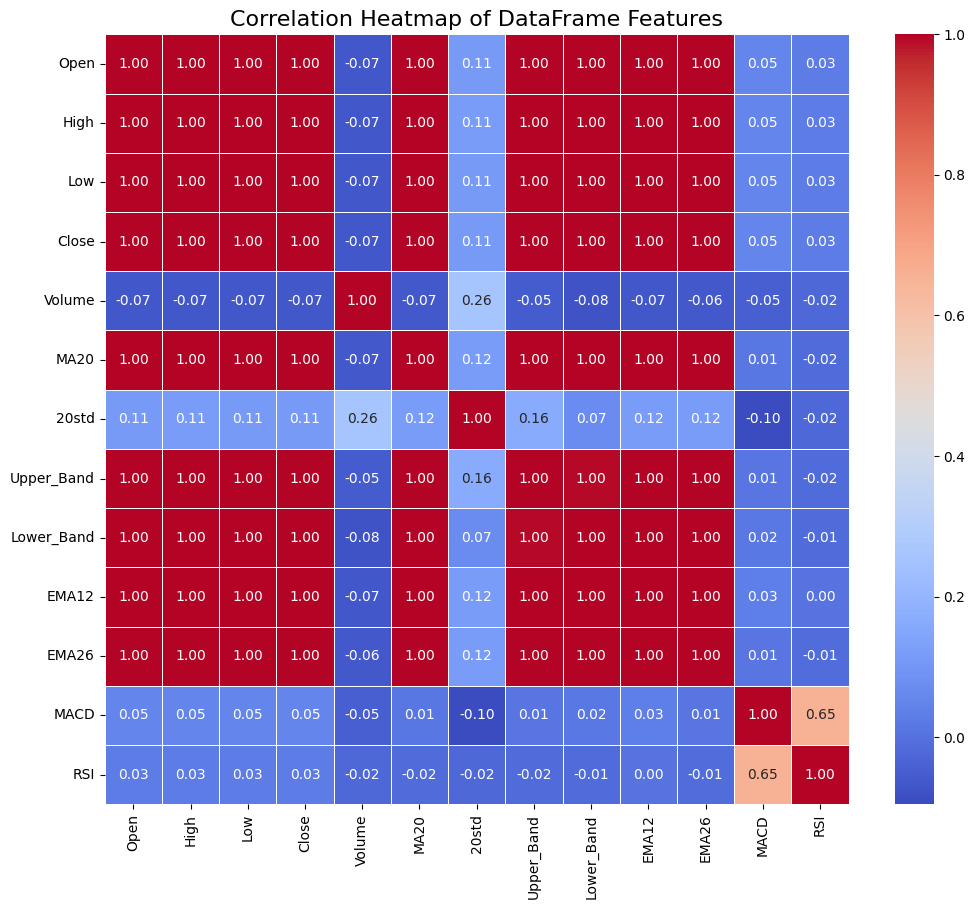

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of DataFrame Features', fontsize=16)
plt.show()

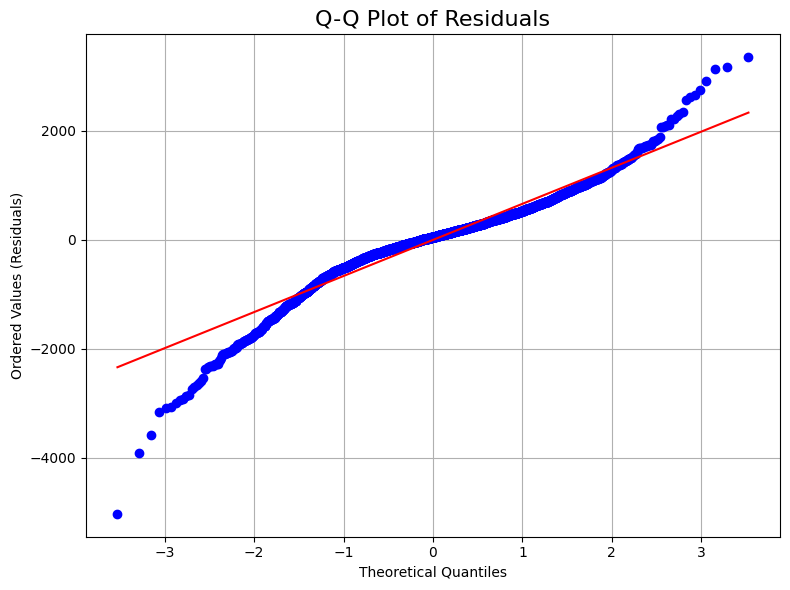

In [8]:
import scipy.stats as stats
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals', fontsize=16)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values (Residuals)')
plt.grid(True)
plt.tight_layout()
plt.show()

104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


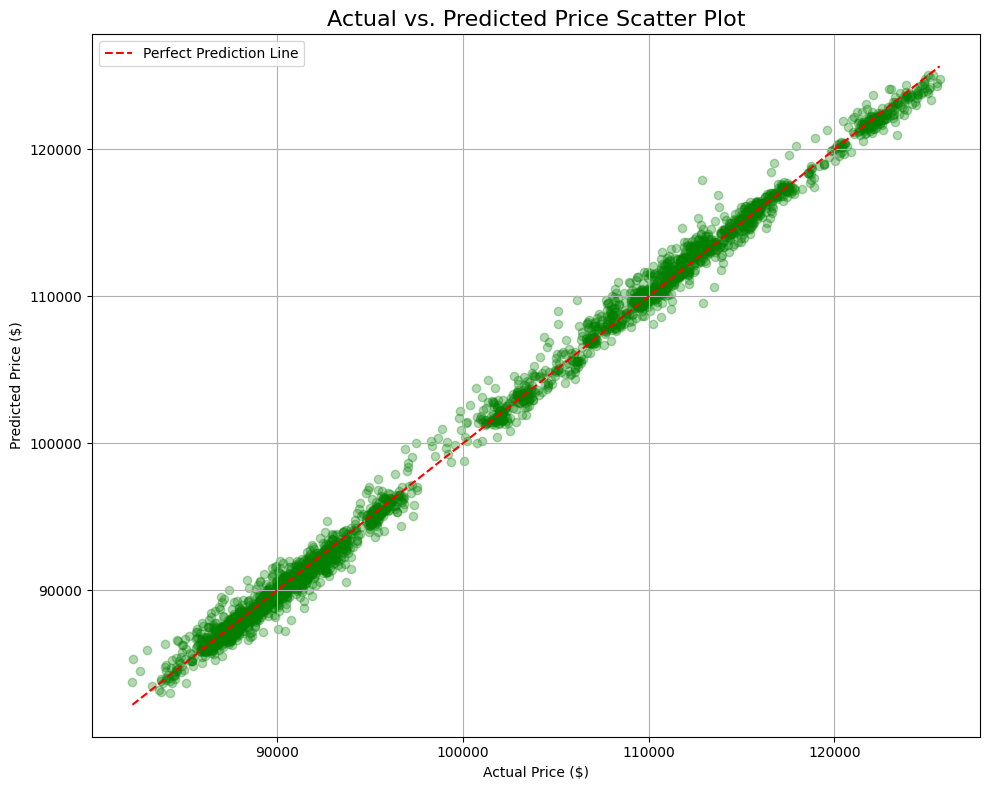

In [9]:
import matplotlib.pyplot as plt
if 'y_actual_unscaled' not in locals() or 'predictions_unscaled' not in locals():
    predictions = model.predict(X_test)
    y_pred_scaled = predictions.flatten()
    predictions_unscaled = (y_pred_scaled * scaler.scale_[0]) + scaler.mean_[0]
    y_test_scaled = y_test
    y_actual_unscaled = (y_test_scaled * scaler.scale_[0]) + scaler.mean_[0]
plt.figure(figsize=(10, 8))
plt.scatter(y_actual_unscaled, predictions_unscaled, alpha=0.3, color='green')
plt.plot([min(y_actual_unscaled), max(y_actual_unscaled)], [min(y_actual_unscaled), max(y_actual_unscaled)], 'r--', label='Perfect Prediction Line')
plt.title('Actual vs. Predicted Price Scatter Plot', fontsize=16)
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Final Prediction Accuracy: 99.52%


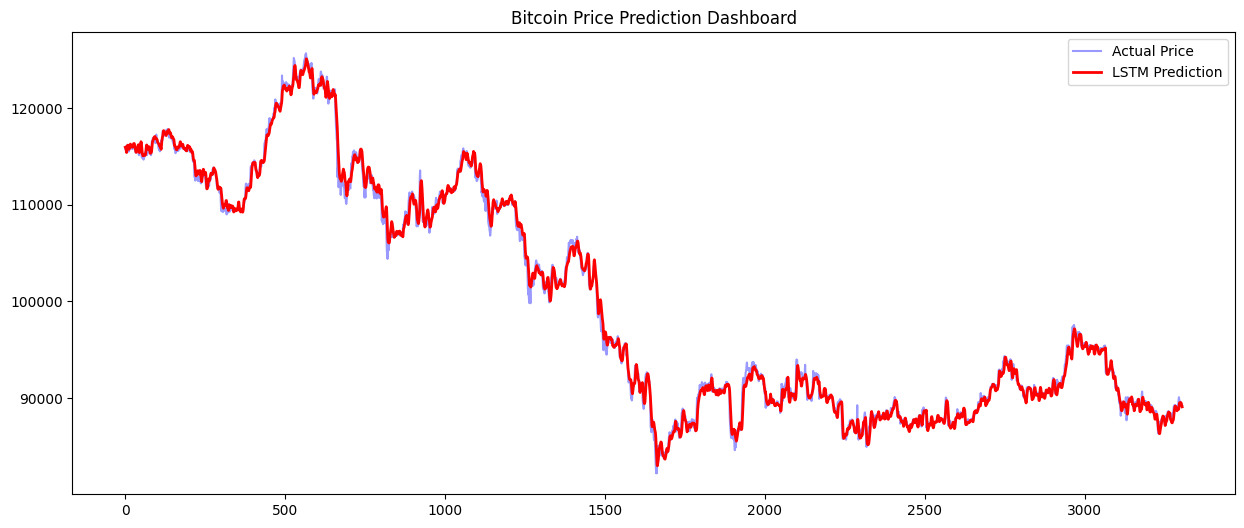

In [10]:
import matplotlib.pyplot as plt
y_pred_scaled = predictions.flatten()
predictions_unscaled = (y_pred_scaled * scaler.scale_[0]) + scaler.mean_[0]
y_test_scaled = y_test
y_actual_unscaled = (y_test_scaled * scaler.scale_[0]) + scaler.mean_[0]
mape = np.mean(np.abs((y_actual_unscaled - predictions_unscaled) / y_actual_unscaled)) * 100
print(f"Final Prediction Accuracy: {100 - mape:.2f}%")
plt.figure(figsize=(15, 6))
plt.plot(y_actual_unscaled, label='Actual Price', color='blue', alpha=0.4)
plt.plot(predictions_unscaled, label='LSTM Prediction', color='red', linewidth=2)
plt.title('Bitcoin Price Prediction Dashboard')
plt.legend()
plt.show()

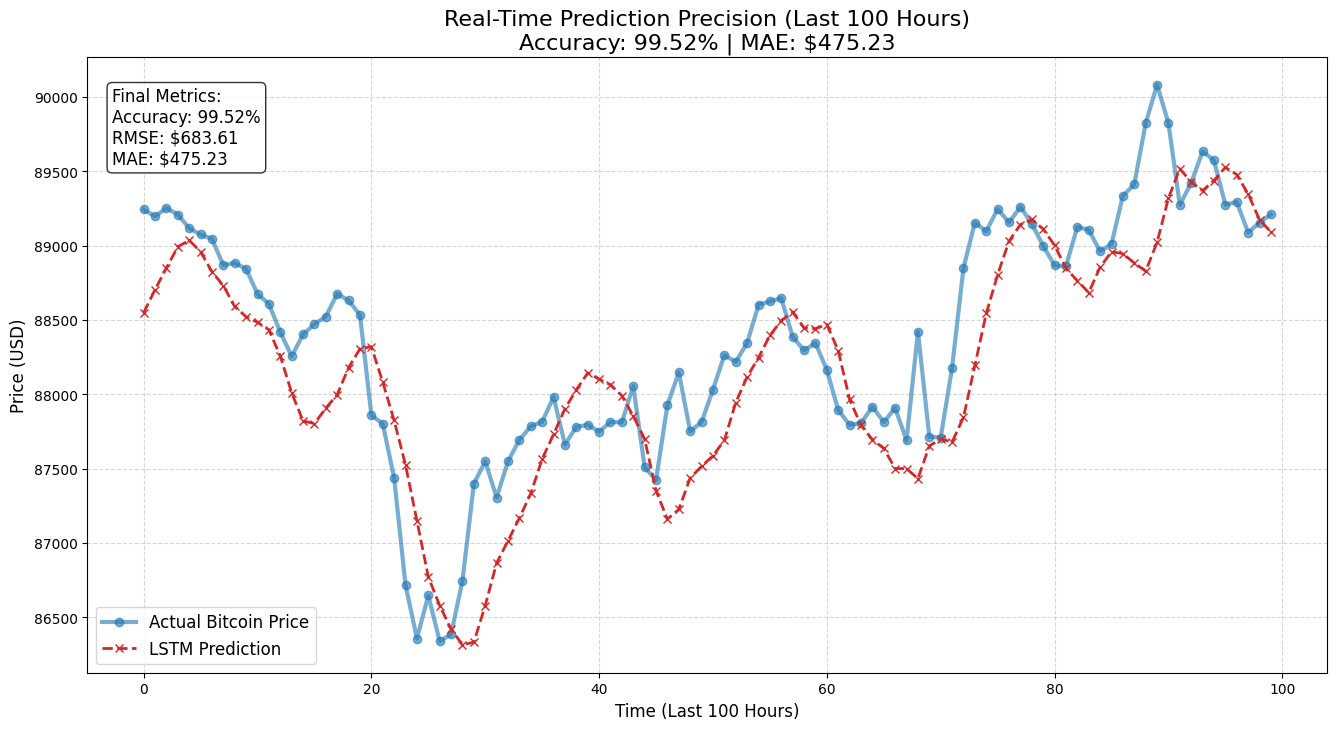

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
if 'y_actual_unscaled' not in locals() or 'predictions_unscaled' not in locals():
    predictions = model.predict(X_test)
    y_pred_scaled = predictions.flatten()
    predictions_unscaled = (y_pred_scaled * scaler.scale_[0]) + scaler.mean_[0]
    y_test_scaled = y_test
    y_actual_unscaled = (y_test_scaled * scaler.scale_[0]) + scaler.mean_[0]
mae = mean_absolute_error(y_actual_unscaled, predictions_unscaled)
if 'rmse' not in locals():
    rmse = np.sqrt(mean_squared_error(y_actual_unscaled, predictions_unscaled))
plt.figure(figsize=(16, 8))
zoom_range = 100
plt.plot(y_actual_unscaled[-zoom_range:], label='Actual Bitcoin Price', color='#1f77b4', linewidth=3, marker='o', alpha=0.6)
plt.plot(predictions_unscaled[-zoom_range:], label='LSTM Prediction', color='#d62728', linestyle='--', linewidth=2, marker='x')
plt.title(f'Real-Time Prediction Precision (Last {zoom_range} Hours)\nAccuracy: {100 - mape:.2f}% | MAE: ${mae:.2f}', fontsize=16)
plt.xlabel('Time (Last 100 Hours)', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
if 'mape' not in locals():
    mape_value = np.mean(np.abs((y_actual_unscaled - predictions_unscaled) / y_actual_unscaled)) * 100
    current_accuracy_percentage = 100 - mape_value
else:
    current_accuracy_percentage = 100 - mape
stats_text = f"Final Metrics:\nAccuracy: {current_accuracy_percentage:.2f}%\nRMSE: ${rmse:.2f}\nMAE: ${mae:.2f}"
plt.gca().text(0.02, 0.95, stats_text, transform=plt.gca().transAxes, fontsize=12,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.show()